### Thực hiện gọi các thư viện cần thiết

In [ ]:
import pickle

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing
from sklearn.preprocessing import StandardScaler

# Scikit-learn: model selection & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn import metrics

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression

# XGBoost
import xgboost as xgb

# System
import warnings

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


# **Khám phá dữ liệu**

In [ ]:
# Đường dẫn đến thư mục chứa dữ liệu
# Bạn có thể thay đổi đường dẫn này phù hợp với máy của bạn
data_path = 'd:/Network detection/'

# Danh sách 43 tên cột cho tập dữ liệu NSL-KDD
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

# Tải dữ liệu từ file local
df_train = pd.read_csv(data_path + "KDDTrain+.txt", names=columns)
print(f"Training data loaded: {df_train.shape}")

df_test = pd.read_csv(data_path + "KDDTest+.txt", names=columns)
print(f"Test data loaded: {df_test.shape}")

# Gộp train và test thành một dataset
df_train = pd.concat([df_train, df_test], axis=0)
df_train = df_train.reset_index(drop=True)

print(f"\nCombined dataset: {df_train.shape}")


Training data loaded: (125973, 43)
Test data loaded: (22544, 43)

Combined dataset: (148517, 43)


In [ ]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.0,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.0,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.0,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df_train['attack'].value_counts()

attack
normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
ftp_write             11
loadmodule            11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm          

In [ ]:
# Nhóm các nhãn (outcome) trong NSL-KDD thành 5 loại: normal, DoS, Probe, U2R, R2L
attack_category = {
    'normal': 'normal',

    # DoS (Denial of Service)
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'apache2': 'DoS', 'udpstorm': 'DoS', 'processtable': 'DoS',

    # Probe (Surveillance/Scanning)
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',

    # U2R (User to Root)
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'xterm': 'U2R', 'ps': 'U2R',
    'sqlattack': 'U2R',

    # R2L (Remote to Local)
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L',
    'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'httptunnel': 'R2L', 'worm': 'R2L'
}

# attack = df_train['attack'].map(attack_category)
# attack.value_counts()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [ ]:
df_train.describe(include='all')

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
count,148517.000000,148517,148517,148517,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517,148517.000000
unique,NaN,3,70,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,121569,48191,89820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77054,NaN
mean,276.779305,NaN,NaN,NaN,4.022795e+04,1.708885e+04,0.000215,0.020523,0.000202,0.189379,0.004323,0.402789,0.255062,0.001508,0.000976,0.273726,0.012073,0.000525,0.004013,0.0,0.000081,0.012308,83.336561,28.251937,0.256925,0.255337,0.137947,0.138487,0.672983,0.067761,0.097441,183.928042,119.462661,0.534521,0.084103,0.145932,0.030584,0.256122,0.251304,0.136220,0.136397,NaN,19.278480
std,2460.683131,NaN,NaN,NaN,5.409612e+06,3.703525e+06,0.014677,0.240069,0.019417,2.013160,0.072248,0.490461,22.231375,0.038807,0.042389,22.689023,0.517863,0.027701,0.095257,0.0,0.008988,0.110259,116.760741,75.369635,0.431918,0.432578,0.339387,0.341783,0.436544,0.194666,0.258886,98.528328,111.232318,0.448061,0.194102,0.308638,0.108975,0.428500,0.429719,0.322741,0.335282,NaN,2.739757
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.000000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.000000,NaN,NaN,NaN,2.780000e+02,5.710000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000,Na

In [ ]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
df_train.loc[df_train['attack'] == 'normal', 'attack'] = 'normal'
df_train.loc[df_train['attack'] != 'normal', 'attack'] = 'attack'

In [ ]:
df_test.loc[df_train['attack'] == 'normal', 'attack'] = 'normal'
df_test.loc[df_train['attack'] != 'normal', 'attack'] = 'attack'

attack
normal    77054
attack    71463
Name: count, dtype: int64


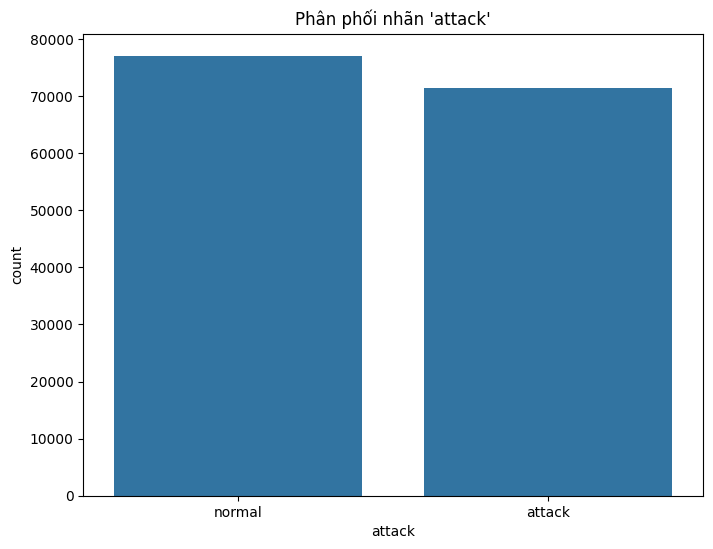

In [ ]:
attack_type_counts = df_train['attack'].value_counts()
print(attack_type_counts)
# Biểu đồ phân phối nhãn attack
plt.figure(figsize=(8,6))
sns.countplot(x=df_train['attack'])
plt.title("Phân phối nhãn 'attack'")
plt.show()

In [ ]:
#Vẽ biểu đồ tròn cho các cột phân loại
def pie_plot(df, columns, rows, cols):
  fig, axes = plt.subplots(rows, cols, figsize=(10,10))
  for ax, col in zip(axes.ravel(), columns):
    df[col].value_counts().plot(ax=ax, kind='pie', fontsize=15, autopct='%1.0f%%')
    ax.set_title(str(col), fontsize=12)

  plt.show()

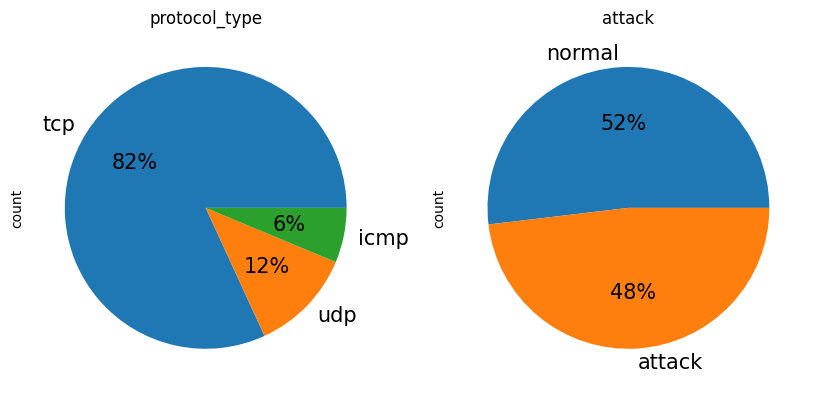

In [ ]:
pie_plot(df_train, ['protocol_type', 'attack'], 1, 2)

# **Visualize data**

## 1. Biểu đồ Boxplot - Phát hiện phân phối và ngoại lai

<Figure size 2000x4000 with 0 Axes>

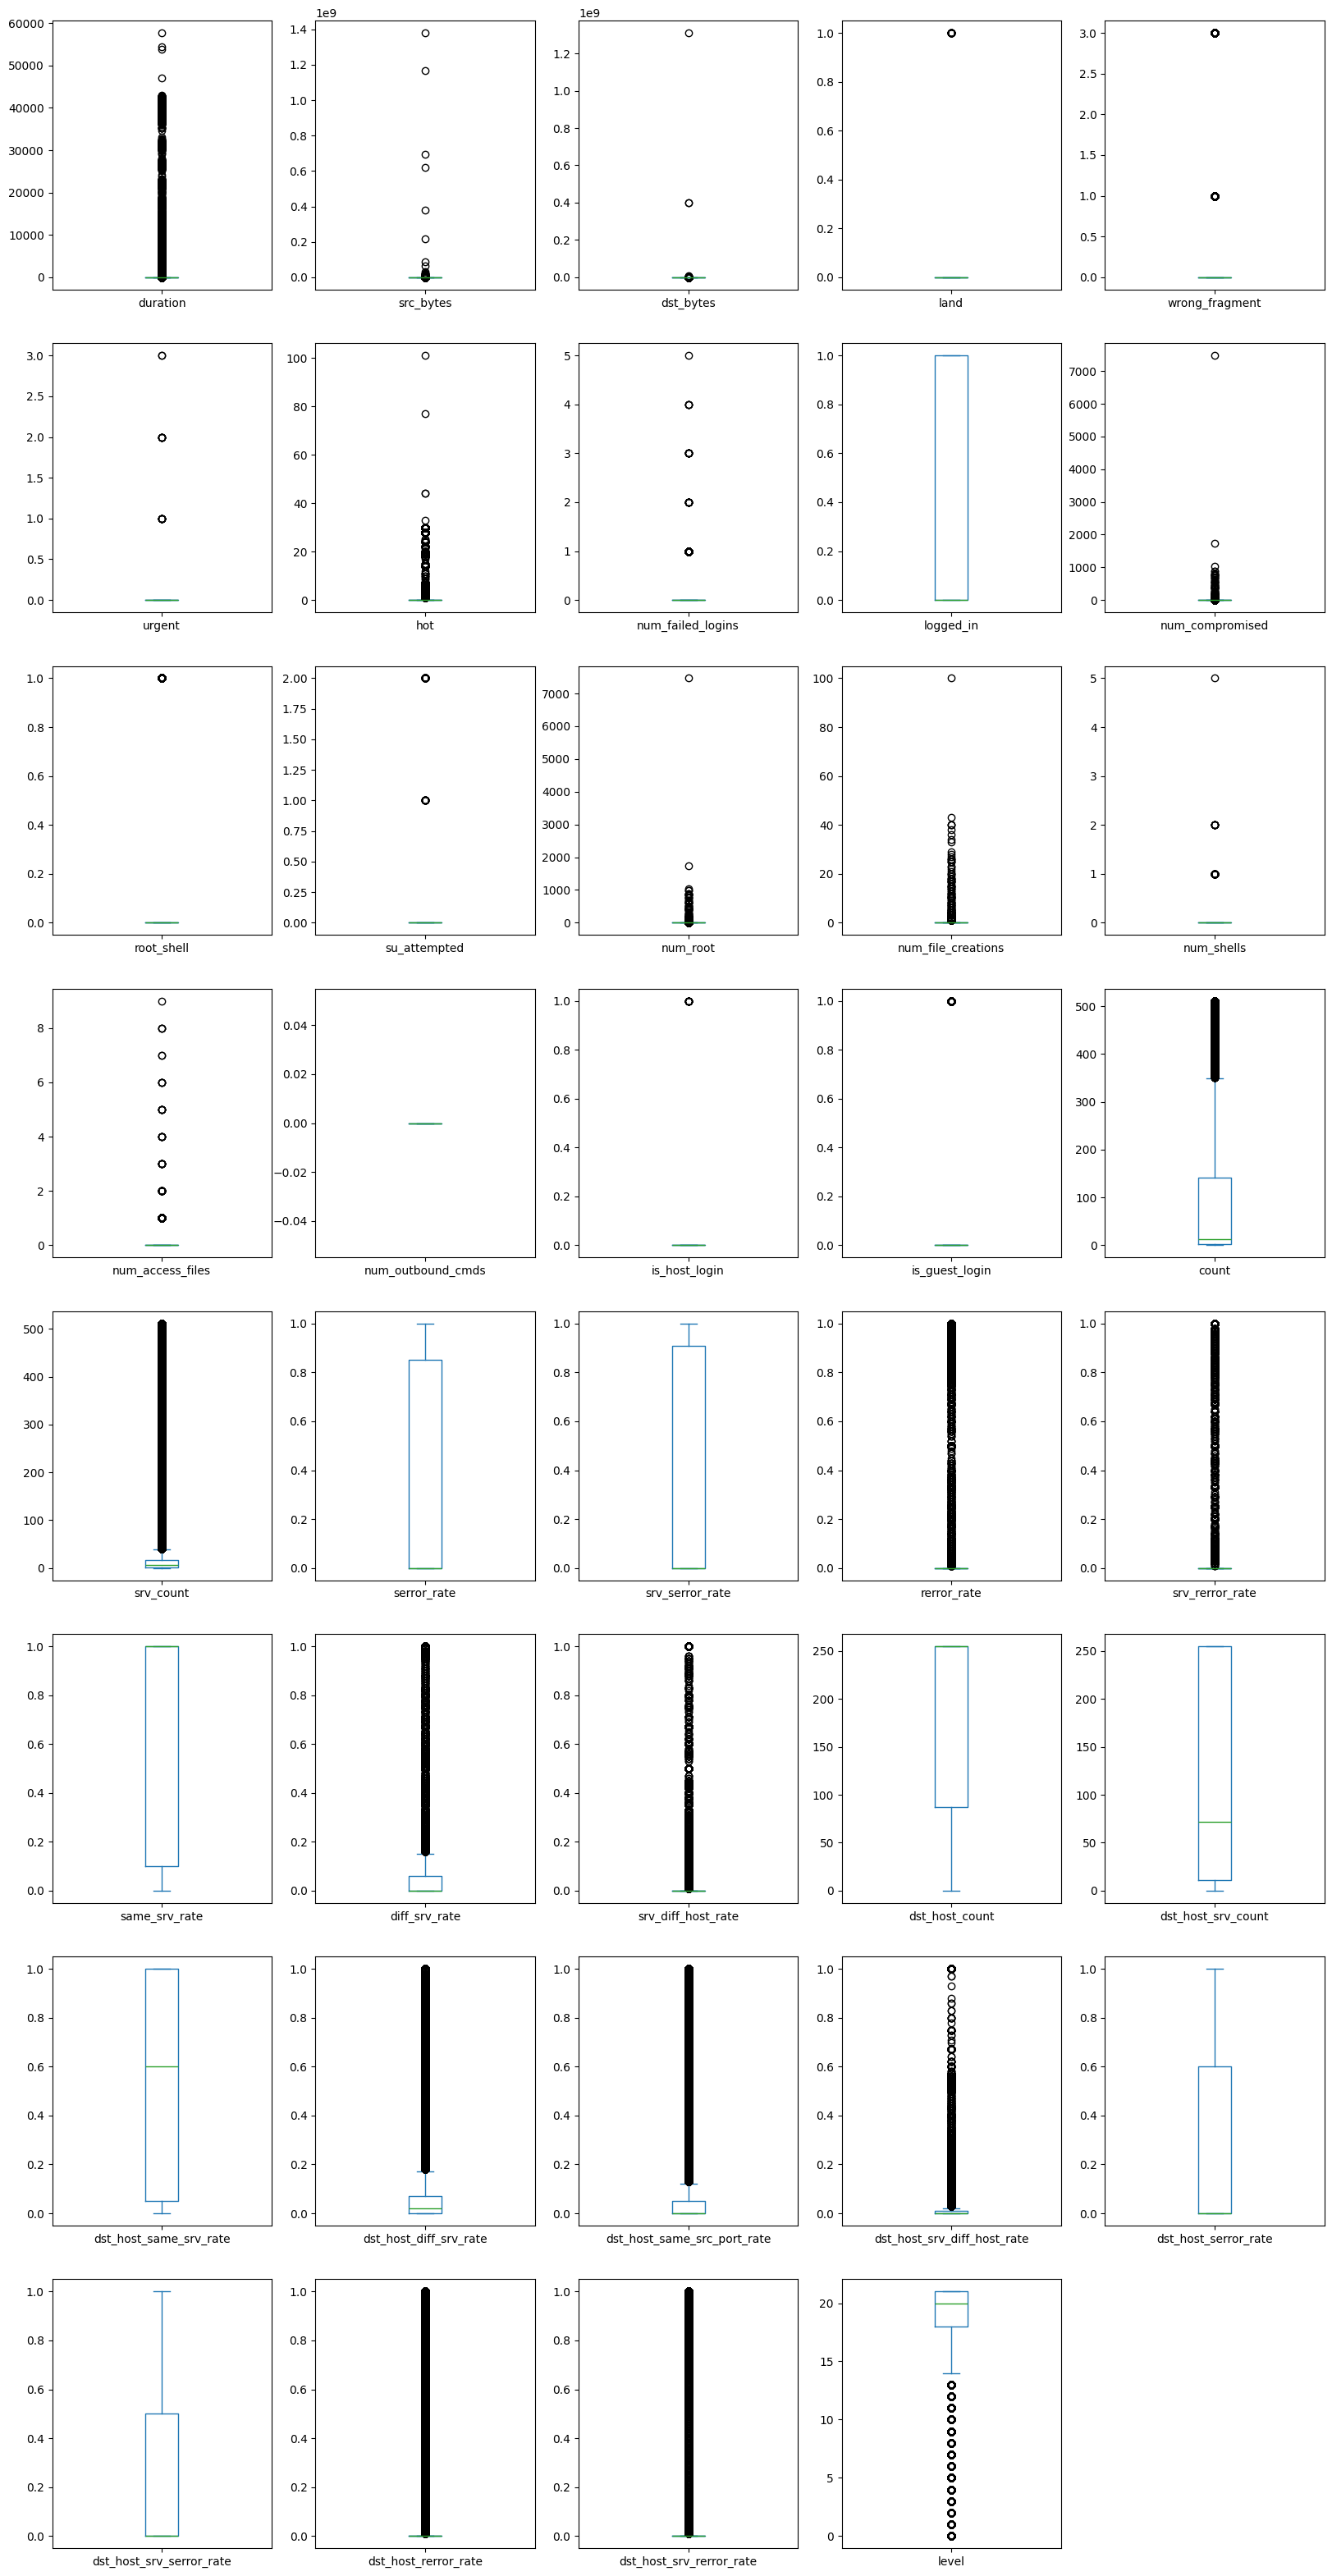

In [ ]:
# Biểu đồ hộp (boxplot)
# Biểu đồ tóm tắt và so sánh sự phân phối của tập dữ liệu
# Hiển thị boxplot cho từng cột số trong DataFrame df_train để phát hiện phân phối và ngoại lai.
plt.figure(figsize=(20, 40))
df_train.plot(kind='box', subplots=True, layout=(8, 5), figsize=(20, 40))
plt.show()

## 2. Biểu đồ Histogram - Phân phối tần suất

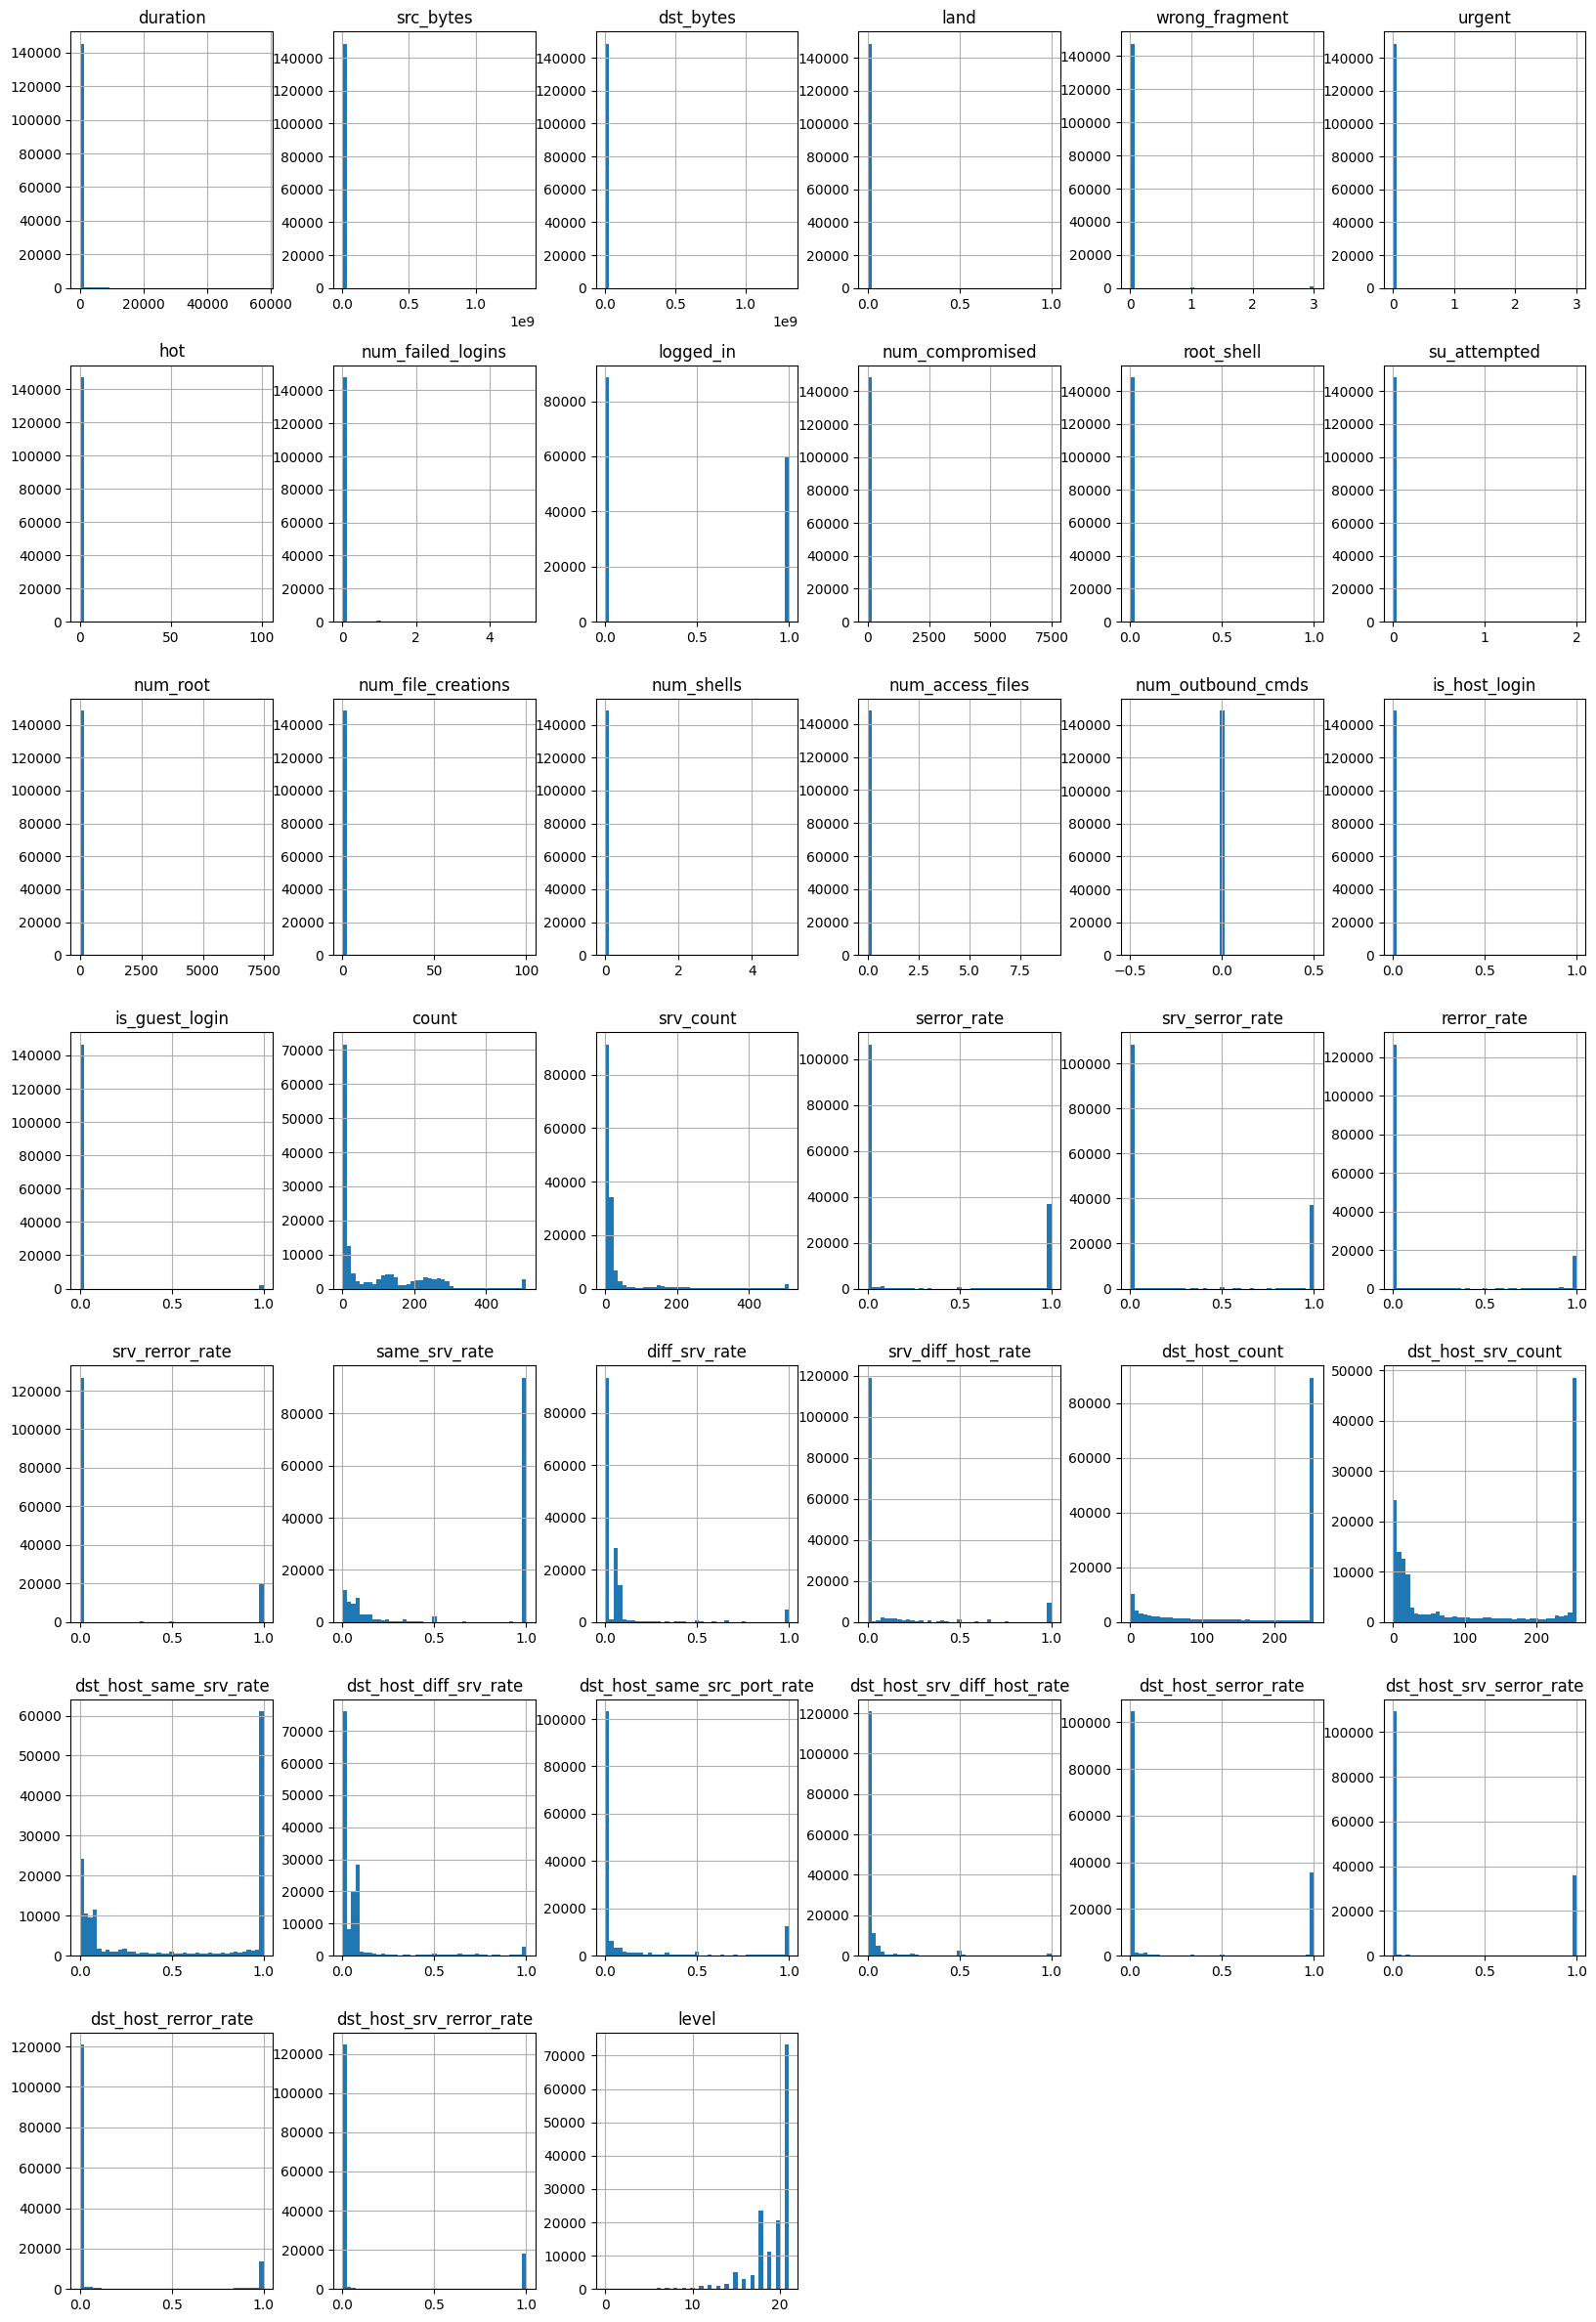

In [ ]:
# Biểu đồ Histogram
# Trực quan hóa sự phân phối tần suất của từng thuộc tính số trong DataFrame df_train.
df_train.hist(bins=43, figsize=(20, 30))
plt.show()

## 3. Số lượng tấn công theo Protocol Type

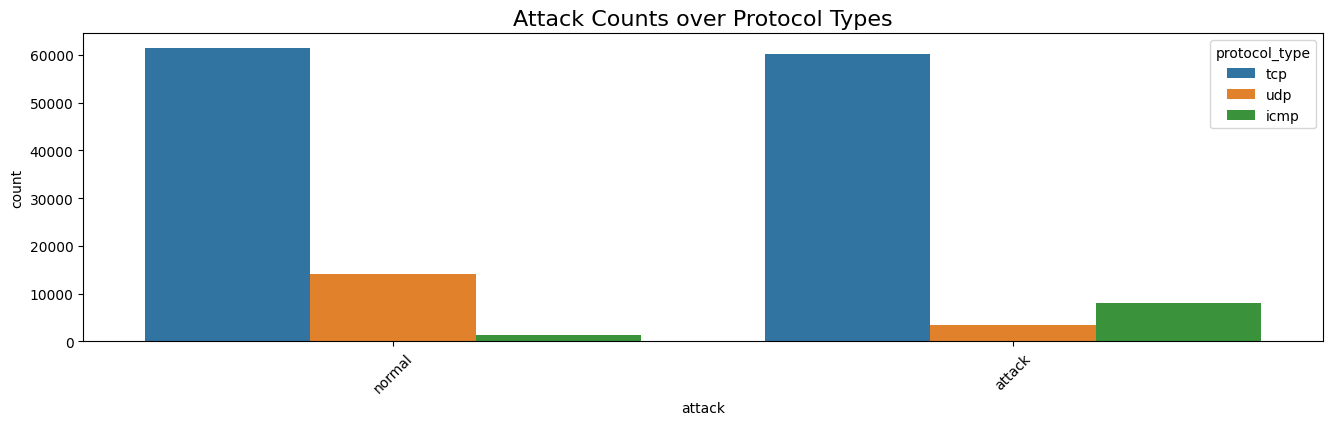

In [ ]:
# Biểu đồ Countplot với phân loại theo 'protocol_type'
# So sánh số lượng tấn công theo từng giao thức.
plt.figure(figsize=(16,4))
sns.countplot(x='attack',data=df_train,hue='protocol_type')
plt.xticks(rotation=45)
plt.title('Attack Counts over Protocol Types',fontdict={'fontsize':16})
plt.show()

## 4. Biểu đồ KDE - Mật độ xác suất

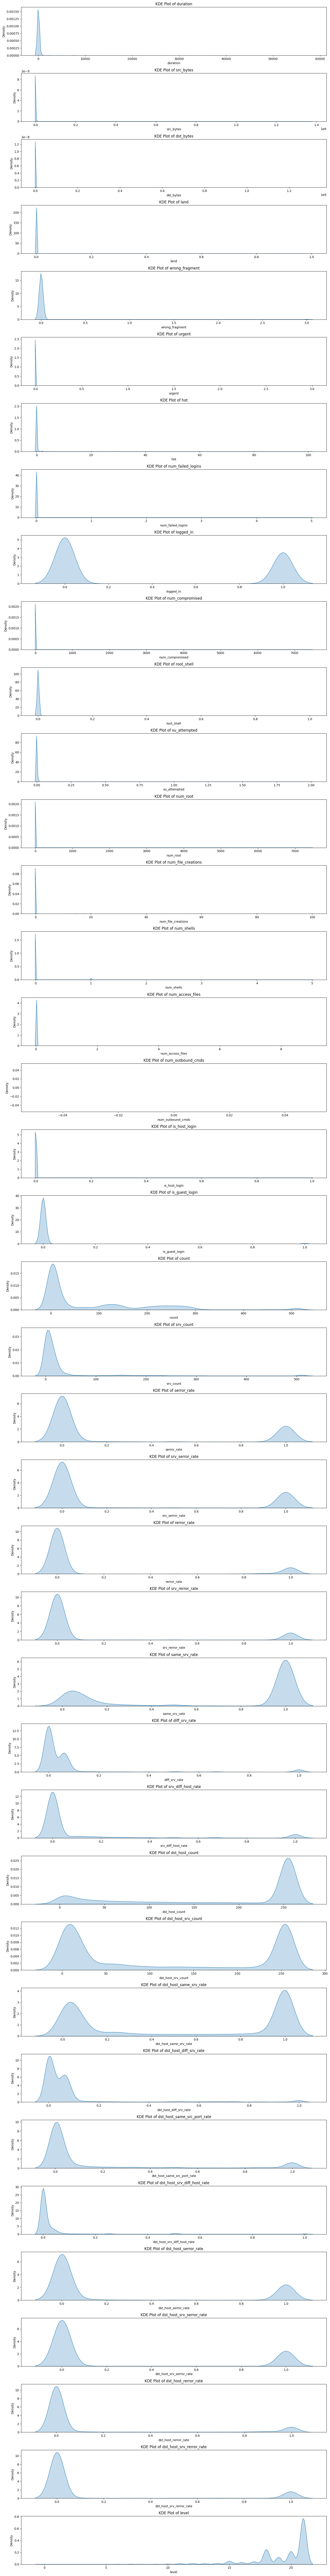

In [ ]:
# Biểu đồ Đường cong Mật độ Hạt nhân (KDE) cho các cột số
# Trực quan hóa ước tính hàm mật độ xác suất của từng cột số trong DataFrame df_train.
numeric_columns = df_train.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numeric_columns) * 3))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 1, i + 1)
    sns.kdeplot(df_train[column], fill=True)
    plt.title(f'KDE Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 5. Số lượng kết nối theo dịch vụ (Service)

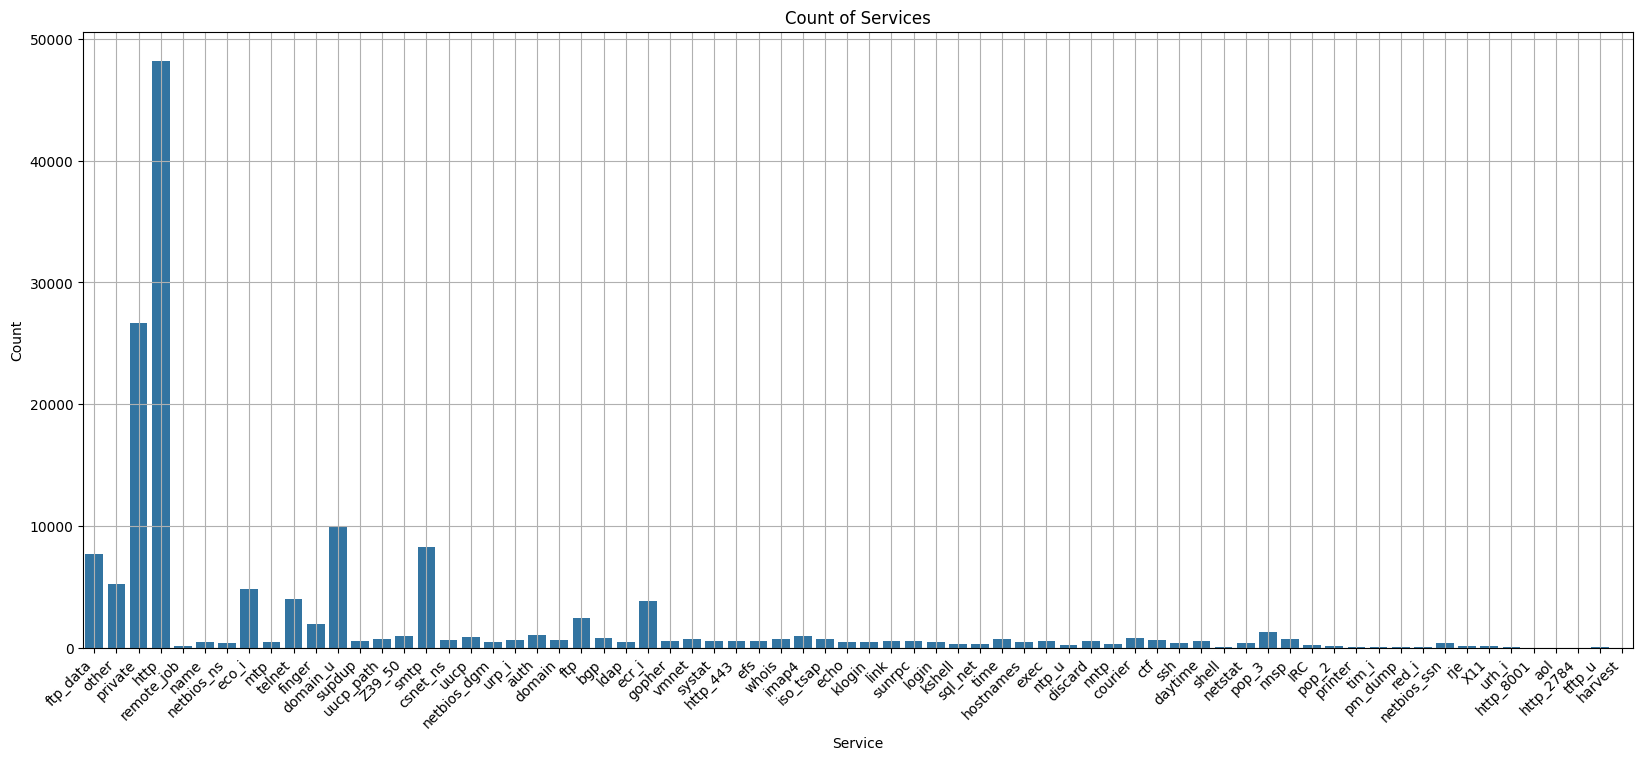

In [ ]:
# Biểu đồ Countplot cho thuộc tính 'service'
# Trực quan hóa số lượng kết nối theo từng loại dịch vụ.
plt.figure(figsize=(20, 8))
ax = sns.countplot(x='service', data=df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Count of Services')
plt.grid(True)
plt.show()

## 6. Phân phối tấn công theo Service

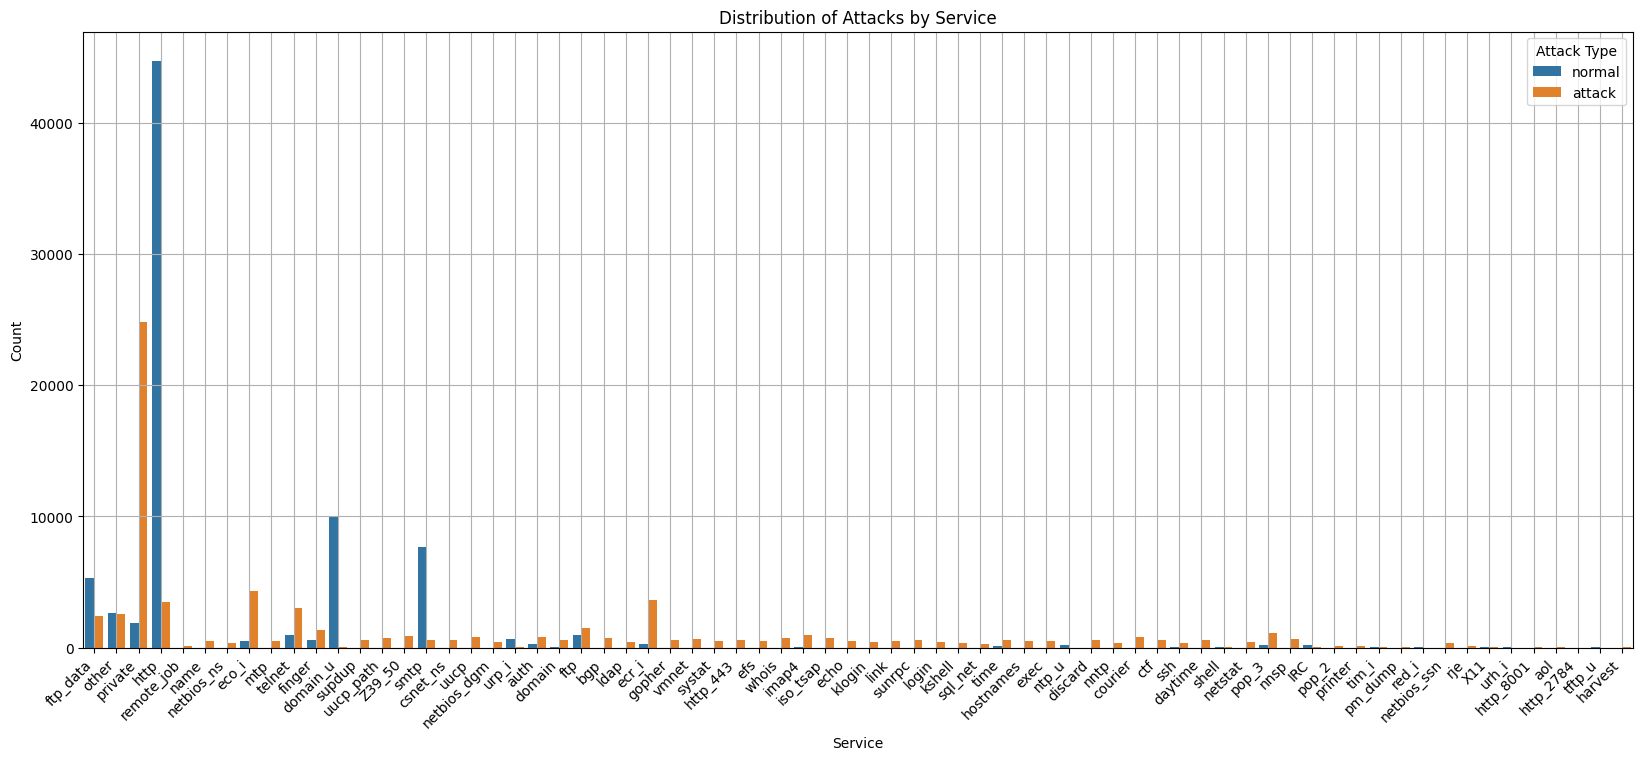

In [ ]:
# Phân phối số lượng tấn công theo từng loại dịch vụ.
plt.figure(figsize=(20, 8))
ax = sns.countplot(x='service', hue='attack', data=df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of Attacks by Service')
plt.legend(title='Attack Type')
plt.grid(True)
plt.show()

## 7. Phân phối tấn công theo Guest Login

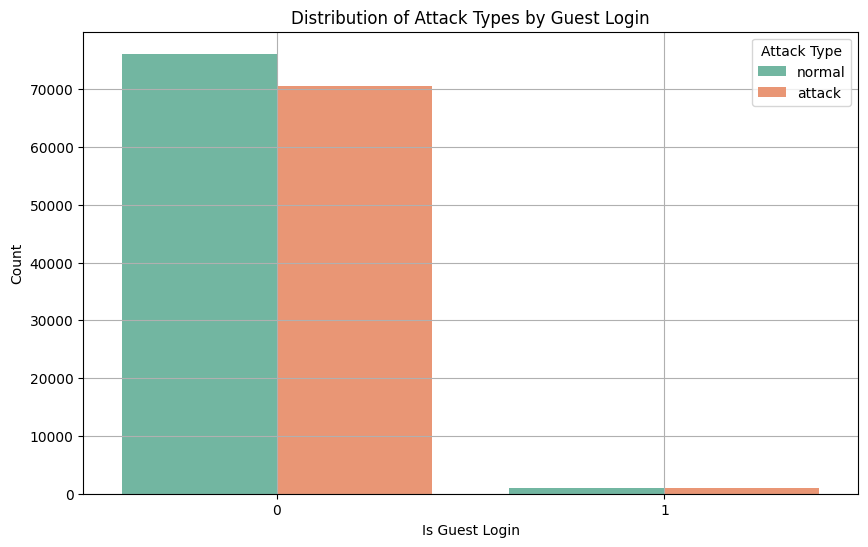

In [ ]:
# Số lượng tấn công phân theo trạng thái đăng nhập khách.
plt.figure(figsize=(10, 6))
sns.countplot(x='is_guest_login', hue='attack', data=df_train, palette='Set2')
plt.xlabel('Is Guest Login')
plt.ylabel('Count')
plt.title('Distribution of Attack Types by Guest Login')
plt.legend(title='Attack Type')
plt.grid(True)
plt.show()

# **Đánh giá hiệu năng mô hình**

In [ ]:
def evaluate_classification(model, name, x_train, x_test, y_train, y_test):
    # Dự đoán
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)

    # Confustion Matrix
    train_confusion_matrix = metrics.confusion_matrix(y_train, train_pred)
    test_confusion_matrix = metrics.confusion_matrix(y_test, test_pred)

    # Tính toán các thông số
    train_accuracy = metrics.accuracy_score(y_train, train_pred)
    train_precision = metrics.precision_score(y_train, train_pred)
    train_recall = metrics.recall_score(y_train, train_pred)
    train_f1 = metrics.f1_score(y_train, train_pred)

    test_accuracy = metrics.accuracy_score(y_test, test_pred)
    test_precision = metrics.precision_score(y_test, test_pred)
    test_recall = metrics.recall_score(y_test, test_pred)
    test_f1 = metrics.f1_score(y_test, test_pred)

    # Tính toán AUC
    train_auc = test_auc = None
    supports_proba = hasattr(model, "predict_proba")
    if supports_proba:
        train_probs = model.predict_proba(x_train)[:, 1]
        test_probs = model.predict_proba(x_test)[:, 1]
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)

    # In ra các chỉ số hiệu suất
    print(f"Training Metrics for {name}:")
    print(f"Accuracy: {train_accuracy*100:.2f}%, Precision: {train_precision*100:.2f}%, Recall: {train_recall*100:.2f}%, F1 Score: {train_f1*100:.2f}%" +
          (f", AUC: {train_auc*100:.2f}%" if train_auc is not None else ""))
    print(f"Testing Metrics for {name}:")
    print(f"Accuracy: {test_accuracy*100:.2f}%, Precision: {test_precision*100:.2f}%, Recall: {test_recall*100:.2f}%, F1 Score: {test_f1*100:.2f}%" +
          (f", AUC: {test_auc*100:.2f}%" if test_auc is not None else ""))

    # Vẽ Confusion Matrix
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    sns.heatmap(train_confusion_matrix, annot=True, fmt='g')
    plt.title(f'Training Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(2, 2, 2)
    sns.heatmap(test_confusion_matrix, annot=True, fmt='g')
    plt.title(f'Testing Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Vẽ đường cong ROC
    if supports_proba:
        fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
        fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

        plt.subplot(2, 2, 3)
        plt.plot(fpr_train, tpr_train, label=f"AUC = {train_auc:.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (Train) for {name}")
        plt.legend(loc="lower right")
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(fpr_test, tpr_test, label=f"AUC = {test_auc:.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (Test) for {name}")
        plt.legend(loc="lower right")
        plt.grid(True)

# **Tiền xử lý dữ liệu**

## Quy trình tiền xử lý dữ liệu

**Các bước thực hiện:**
1. Xử lý dữ liệu trùng lặp
2. Nhị phân hóa nhãn 'attack' (normal = 0, attack = 1)  
3. One-hot encoding cho các biến phân loại (protocol_type, service, flag)
4. Chuẩn hóa các biến số bằng StandardScaler
5. Lưu scaler và danh sách cột để tái sử dụng

In [ ]:
# Danh sách các cột phân loại (categorical) và nhãn (attack)
cat_cols = ['is_host_login','protocol_type','service','flag','land',
            'logged_in','is_guest_login', 'level', 'attack']


def preprocessing(df_data):
  """
  Hàm tiền xử lý dữ liệu NSL-KDD
  
  Quy trình:
  1. Xử lý dữ liệu trùng lặp
  2. Nhị phân hóa nhãn 'attack' (normal=0, attack=1)
  3. One-hot encoding cho các cột phân loại (protocol_type, service, flag)
  4. Chuẩn hóa các cột số bằng StandardScaler
  """
  
  # Bước 1: Xử lý dữ liệu trùng lặp (trước khi xử lý)
  print(f"Số dòng trước khi xử lý duplicate: {len(df_data)}")
  df_data = df_data.drop_duplicates()
  print(f"Số dòng sau khi xử lý duplicate: {len(df_data)}")
  
  # Bước 2: Nhị phân hóa nhãn 'attack' (trước khi one-hot encoding)
  df_data['attack'] = df_data['attack'].apply(lambda x: 0 if x == 'normal' else 1)
  print(f"\nPhân phối nhãn attack:")
  print(df_data['attack'].value_counts())
  
  # Bước 3: One-hot encode cho các cột phân loại
  # Chỉ encode 3 cột: protocol_type, service, flag
  df_data = pd.get_dummies(df_data, columns=['protocol_type', 'service', 'flag'], drop_first=False)
  
  # Lưu danh sách cột dummy để sử dụng sau này
  dummy_cols = [c for c in df_data.columns if c.startswith("protocol_type_")
                                             or c.startswith("service_")
                                             or c.startswith("flag_")]
  print(f"\nSố cột sau one-hot encoding: {len(dummy_cols)}")
  with open("dummy_columns.pkl", "wb") as f:
    pickle.dump(dummy_cols, f)
  
  # Bước 4: Chuẩn hóa các cột số (cuối cùng)
  # Lấy các cột dạng số (loại bỏ các cột categorical đã được encode và cột attack, level)
  num_cols = [col for col in df_data.columns 
              if col not in dummy_cols 
              and col not in ['attack', 'level', 'is_host_login', 'land', 'logged_in', 'is_guest_login']]
  
  print(f"\nSố cột số cần chuẩn hóa: {len(num_cols)}")
  
  scaler = StandardScaler()
  df_data[num_cols] = scaler.fit_transform(df_data[num_cols])
  
  # Lưu scaler
  with open("scaler_numeric.pkl", "wb") as f:
    pickle.dump(scaler, f)
  
  print(f"\nSố cột cuối cùng trong dataset: {df_data.shape[1]}")
  print(f"Số dòng cuối cùng: {df_data.shape[0]}")
  
  return df_data

In [ ]:
df_train_preprocessed = preprocessing(df_train)

Số dòng trước khi xử lý duplicate: 148517
Số dòng sau khi xử lý duplicate: 147888

Phân phối nhãn attack:
attack
0    76967
1    70921
Name: count, dtype: int64

Số cột sau one-hot encoding: 84

Số cột số cần chuẩn hóa: 34

Số cột cuối cùng trong dataset: 124
Số dòng cuối cùng: 147888

Số cột sau one-hot encoding: 84

Số cột số cần chuẩn hóa: 34

Số cột cuối cùng trong dataset: 124
Số dòng cuối cùng: 147888


In [ ]:
# Tách đặc trưng và nhãn
x = df_train_preprocessed.drop(['attack', 'level'] , axis = 1) # Dữ liệu đầu vào (features)
y = df_train_preprocessed['attack']                             # Nhãn nhị phân (normal = 0, attack = 1)

# Chia tập train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {x_train.shape}")
print(f"Test set size: {x_test.shape}")
print(f"Number of features: {x_train.shape[1]}")

Training set size: (118310, 122)
Test set size: (29578, 122)
Number of features: 122


# **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression với dữ liệu gốc (full features)
print("Training Logistic Regression on full features...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(x_train, y_train)

Training Logistic Regression on full features...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# Đánh giá Logistic Regression
y_pred_lr = lr_model.predict(x_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     15394
           1       0.97      0.94      0.96     14184

    accuracy                           0.96     29578
   macro avg       0.96      0.96      0.96     29578
weighted avg       0.96      0.96      0.96     29578



Training Metrics for Logistic Regression:
Accuracy: 95.79%, Precision: 96.57%, Recall: 94.58%, F1 Score: 95.56%, AUC: 99.13%
Testing Metrics for Logistic Regression:
Accuracy: 95.81%, Precision: 96.85%, Recall: 94.32%, F1 Score: 95.57%, AUC: 99.14%


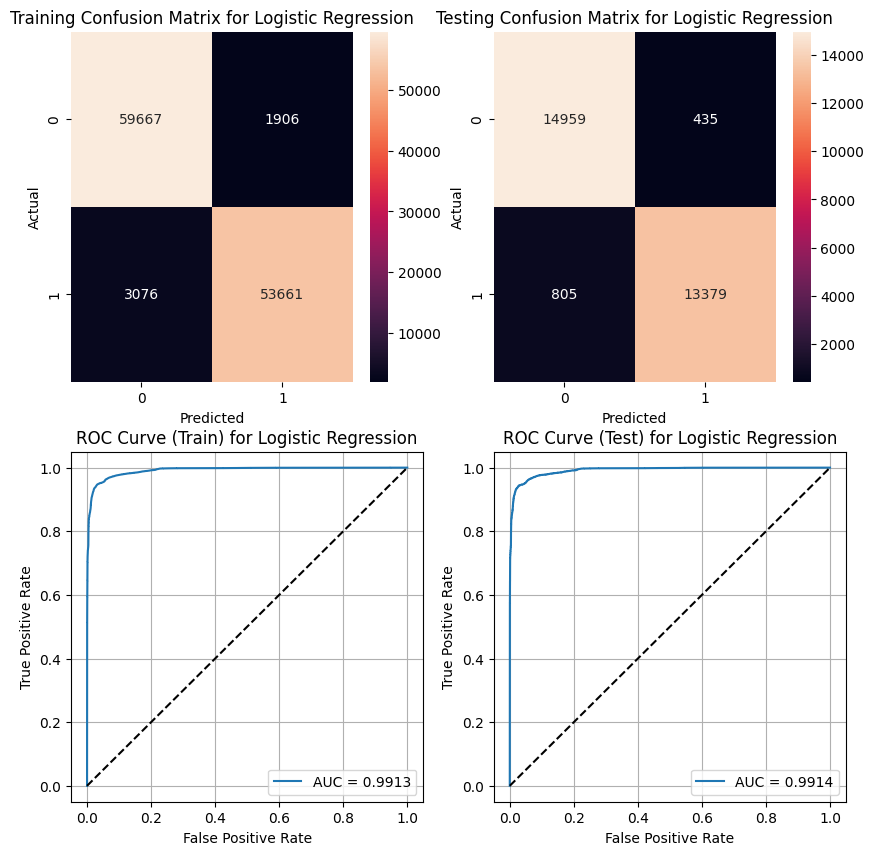

In [ ]:
# Đánh giá chi tiết với confusion matrix và ROC curves
evaluate_classification(lr_model, "Logistic Regression", x_train, x_test, y_train, y_test)

In [ ]:
# Lưu mô hình Logistic Regression
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Logistic Regression model saved as 'logistic_regression_model.pkl'")

Logistic Regression model saved as 'logistic_regression_model.pkl'


# **XGBoost Model**

In [ ]:
# Train XGBoost với dữ liệu gốc (full features)
print("Training XGBoost on full features...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(x_train, y_train)

Training XGBoost on full features...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# Đánh giá XGBoost
y_pred_xgb = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15394
           1       1.00      0.99      0.99     14184

    accuracy                           0.99     29578
   macro avg       0.99      0.99      0.99     29578
weighted avg       0.99      0.99      0.99     29578



Training Metrics for XGBoost:
Accuracy: 99.57%, Precision: 99.69%, Recall: 99.42%, F1 Score: 99.55%, AUC: 99.99%
Testing Metrics for XGBoost:
Accuracy: 99.49%, Precision: 99.65%, Recall: 99.29%, F1 Score: 99.47%, AUC: 99.99%


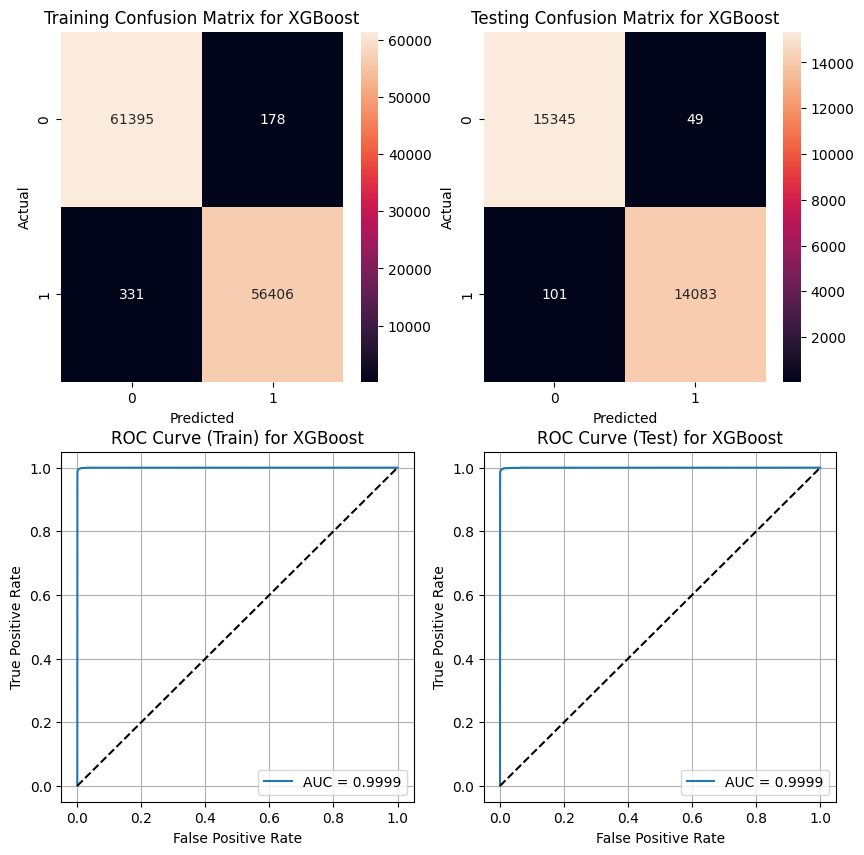

In [ ]:
# Đánh giá chi tiết với confusion matrix và ROC curves
evaluate_classification(xgb_model, "XGBoost", x_train, x_test, y_train, y_test)

In [ ]:
# Lưu mô hình XGBoost
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("XGBoost model saved as 'xgboost_model.pkl'")

XGBoost model saved as 'xgboost_model.pkl'


# **So sánh hiệu suất 2 mô hình**

In [ ]:
# So sánh Logistic Regression và XGBoost
models = {
    'Logistic Regression': lr_model,
    'XGBoost': xgb_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(x_test)[:, 1]
        auc = roc_auc_score(y_test, y_probs)
    else:
        auc = None
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON: LOGISTIC REGRESSION vs XGBOOST")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL COMPARISON: LOGISTIC REGRESSION vs XGBOOST
              Model  Accuracy  Precision   Recall  F1 Score     AUC
Logistic Regression  0.958077   0.968510 0.943246  0.955711 0.99143
            XGBoost  0.994929   0.996533 0.992879  0.994703 0.99985


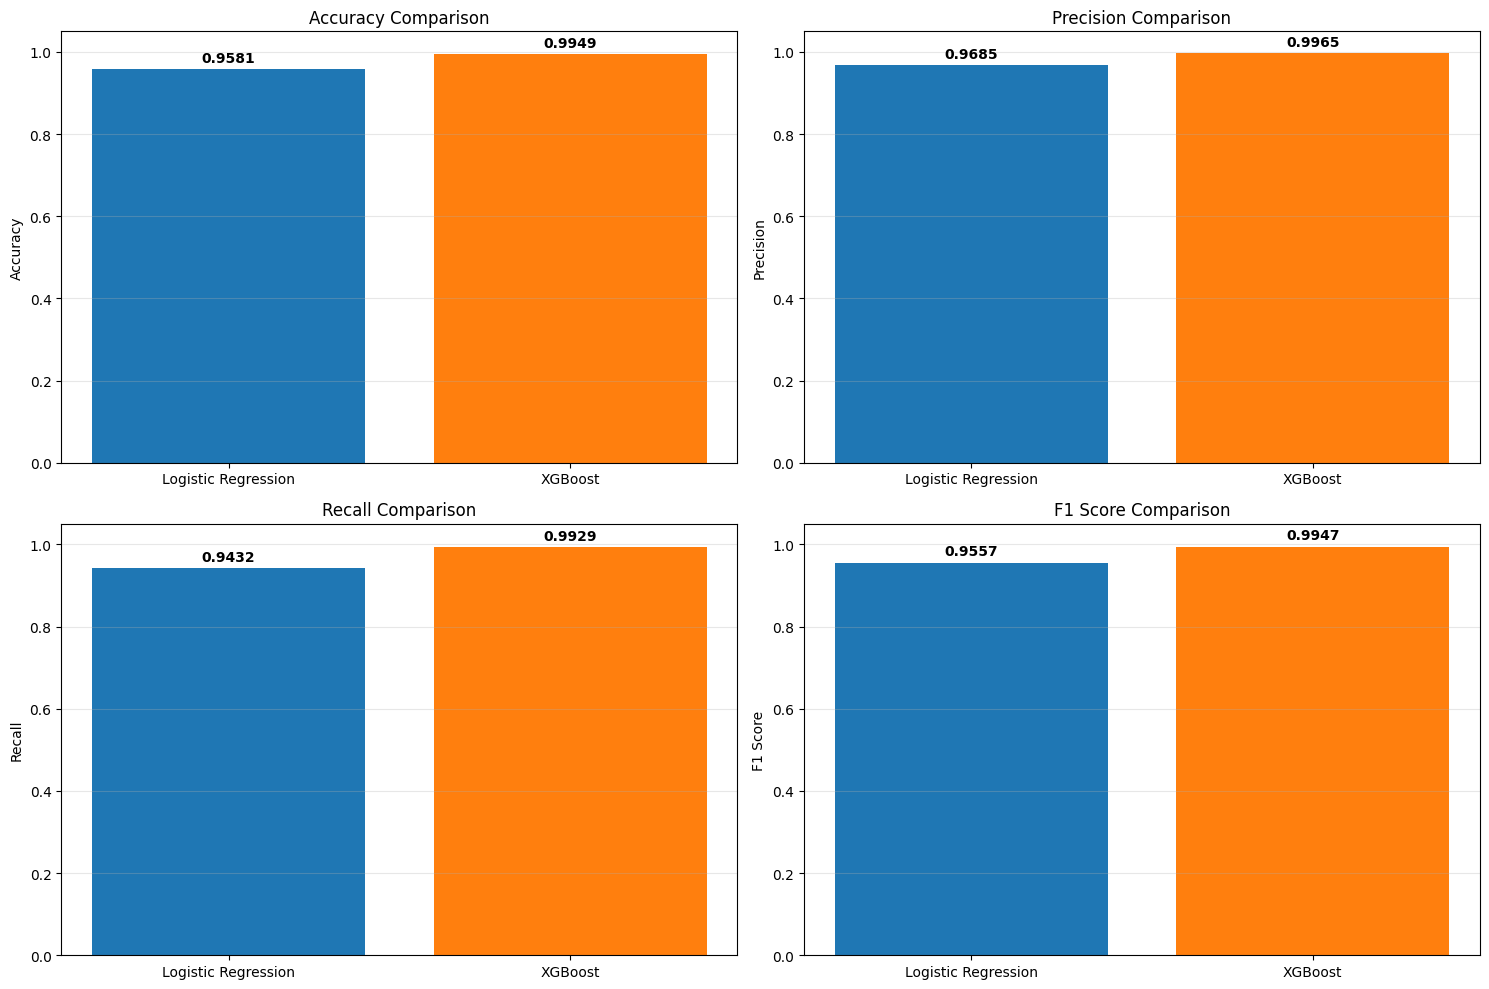

In [ ]:
# Biểu đồ so sánh hiệu suất
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#1f77b4', '#ff7f0e']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    ax.bar(results_df['Model'], results_df[metric], color=colors)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    # Thêm giá trị trên cột
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()